# Implementation of Ensemble Learning
### 1. Import of data
### 2. Split the data into train, valid and test data
### 3. Application of Ensemble Learning
### 4. Optimization: External training (Analysis of ensemble components)

**1. Import of data**

In [0]:
import pandas as pd
import numpy as np

# Import train_test_split function
from sklearn.model_selection import train_test_split

from google.colab import drive
drive.mount('/content/drive',force_remount=True)

# Doc2vec
# CSVLInk = r'/content/drive/My Drive/Feature_generated_sets/doc2vec/Pretrained_withScore.csv'
# hotelData = pd.read_csv(CSVLInk)

# Bag of Words - TF / TF-IDF
CSVLInk = r'/content/drive/My Drive/Feature_generated_sets/BOW/tf_561-woerter.pkl'

# FastText
# CSVLInk = r'/content/drive/My Drive/Feature_generated_sets/fast_text/fast_text_nonswr.pkl'
hotelData =pd.DataFrame(np.load(CSVLInk,allow_pickle=True))

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**2. Split the data into train, valid and test data**

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def train_test_valid_split(df,upsampling=True):
    train,test = train_test_split(df,test_size=0.3,stratify=df["Reviewer_Score"], random_state=42)
    test,valid = train_test_split(test,test_size=0.5,stratify=test["Reviewer_Score"], random_state=42)
    #In summary, the following split: 70% training, 15% validation, 15% testing


    unique, counts_train = np.unique(train["Reviewer_Score"], return_counts=True)
    if(upsampling): #Idea: Reduce class 0 to the size of class 1, dupliate samples from class 2 to the size of class 1
        train_0 = train[train["Reviewer_Score"]==0].sample(frac=(counts_train[1]/counts_train[0]), random_state=42)
        train_1 = train[train["Reviewer_Score"]==1]
        train_2 = train[train["Reviewer_Score"]==2].sample(frac=(counts_train[1]/counts_train[2]),replace=True, random_state=42)
        train = train_0.append(train_1).append(train_2)
    unique, counts_train = np.unique(train["Reviewer_Score"], return_counts=True)
    plt.bar(unique, counts_train)
    #print(counts_train)
    
    unique, counts = np.unique(test["Reviewer_Score"], return_counts=True)
    plt.bar(unique, counts)
    #print(counts)
    
    unique, counts = np.unique(valid["Reviewer_Score"], return_counts=True)
    plt.bar(unique, counts)
    #print(counts)

        

    plt.title('Class Frequency')
    plt.xlabel('Class')
    plt.ylabel('Frequency')

    #plt.show()
    
    return train,valid,test

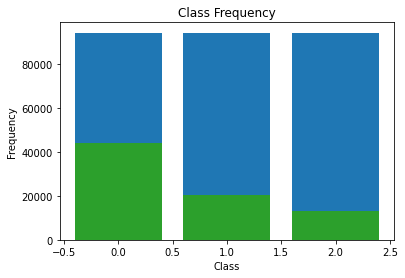

In [0]:
train, valid, test = train_test_valid_split(hotelData,upsampling=True)

y_train = train["Reviewer_Score"]
X_train = train.drop(["Reviewer_Score"], axis=1)

y_test = valid["Reviewer_Score"]
X_test = valid.drop(["Reviewer_Score"], axis=1)

y_testTEST = test["Reviewer_Score"]
X_testTEST = test.drop(["Reviewer_Score"], axis=1)

#To save Ram
train=0
valid=0
test=0
hotelData=0

**3. Application of Ensemble Learning**


In [0]:
from sklearn.svm import SVC #Quelle Buch
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
import time

firstTime = time.time()
#svm_estimator = SVC(gamma='auto',probability=True) ('svc', svm_estimator),
lsvc_estimator = LinearSVC(random_state=0, C=5,dual=False, multi_class='ovr',tol=0.01)
rf_estimator = RandomForestClassifier(max_depth=300, min_samples_split=4, n_estimators=300, random_state=0, n_jobs=-1)
lg_estimator = LogisticRegression(random_state=0, n_jobs=-1)
mnb_estimator = MultinomialNB()
#knn_estimator = KNeighborsClassifier(n_neighbors=3) ('knn',knn_estimator),
#gaus_estimator = GaussianNB(),('gau',gaus_estimator)


voting_clf = VotingClassifier(
    estimators=[('lr', lg_estimator), ('rf', rf_estimator),('svc',lsvc_estimator),('mnb',mnb_estimator)
 ],
    voting='hard', n_jobs=-1) 
voting_clf = voting_clf.fit(X_train, y_train)
print ("--- %s seconds ---" % round(time.time()-firstTime,4))

In [0]:
firstTime = time.time()
y_pred = voting_clf.predict(X_test)
print ("--- %s seconds ---" % round(time.time()-firstTime,4))

In [0]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
print(f1_score(y_test, y_pred, average='macro'))
print(accuracy_score(y_test, y_pred))

0.5923237029785612
0.6351908584428847


**4. Optimization: External training (Analysis of ensemble components)**

In [0]:
firstTime = time.time() #Source: Praxiseinstieg Machine Learning mit Scikit-Learn und Tensor Flow, Aurélien Géron, 2018, O’REILLY (book)
for clf in (rf_estimator, lg_estimator, knn_estimator, gaus_estimator, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print ("\n")
    print ("--- %s seconds ---" % round(time.time()-firstTime,4))
    firstTime = time.time() 
    print(clf.__class__.__name__, f1_score(y_test, y_pred, average='macro'))
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

RandomForestClassifier 0.5230893637527253
RandomForestClassifier 0.6436373036902993


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression 0.5706798576045605
LogisticRegression 0.6627674012796484
KNeighborsClassifier 0.3857872710926082
KNeighborsClassifier 0.5572933497059394
GaussianNB 0.518200158834987
GaussianNB 0.5748723583015576


/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


VotingClassifier 0.5438731072486442
VotingClassifier 0.6401473534544044
